# Import Library

In [286]:
# --- LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from kbba import slang_dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import csv
from io import StringIO
import requests
from sklearn.utils import class_weight

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

# Loading Dataset

In [287]:
# --- Load Data ---
try:
    df = pd.read_csv('data_sentiment.csv', encoding='utf-8')
except FileNotFoundError:
    print("Error: File 'data_sentiment.csv' tidak ditemukan. Pastikan file ada di direktori yang sama.")
    exit()

In [288]:
# --- Information about the dataset ---
print("Informasi Dataset Awal:")
df.info()

Informasi Dataset Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  20377 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          5114 non-null   object
 9   repliedAt             5114 non-null   object
 10  appVersion            20377 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [289]:
# Membuat salinan DataFrame agar tidak mengubah yang asli
df_filled = df.copy()

# Mengisi missing values
df_filled['reviewCreatedVersion'] = df_filled['reviewCreatedVersion'].fillna('Tidak Diketahui')
df_filled['appVersion'] = df_filled['appVersion'].fillna('Tidak Diketahui')
df_filled['replyContent'] = df_filled['replyContent'].fillna('Tidak Ada Balasan')
df_filled['repliedAt'] = df_filled['repliedAt'].fillna('Tidak Ada Balasan')

# Verifikasi missing values setelah diisi
print("\nInformasi Dataset Setelah Pengisian:")
print(df_filled.info())


Informasi Dataset Setelah Pengisian:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  30000 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          30000 non-null  object
 9   repliedAt             30000 non-null  object
 10  appVersion            30000 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB
None


In [290]:
# Melihat duplikasi data
print("\nJumlah Data Duplikat:", df_filled.duplicated().sum())


Jumlah Data Duplikat: 0


# Preprocessing Text

In [291]:
def preprocess_text(text):
    text = re.sub(r'@[A-Za-z0-9]+|#|RT[\s]+|https?:\/\/\S+|[^\w\s]', '', text).lower()
    text = re.sub(r'(.)\1+', r'\1', text)
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    tokens = word_tokenize(' '.join(normalized_words))
    stop_words_indonesia = set(stopwords.words('indonesian'))
    filtered_tokens = [word for word in tokens if word not in stop_words_indonesia]
    return ' '.join(filtered_tokens)

df_filled['text_stopword'] = df_filled['content'].apply(lambda x: preprocess_text(x).split())
df_filled['text_akhir'] = df_filled['text_stopword'].apply(lambda words: ' '.join(words))

In [292]:
def normalize_text(text):
    words = text.lower().split()
    normalized = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized)

# Contoh pemakaian fungsi normalize_text:
kalimat = "ak lg maen game playtogether bgs bangettt dan seruuuu"
# Normalisasi teks dengan fungsi normalize_text
try:
    hasil = normalize_text(kalimat)
    print("\nContoh Normalisasi Teks Terpisah:")
    print(f"Teks asli: {kalimat}")
    print(f"Teks ternormalisasi: {hasil}")
except NameError:
    print("\nError: Variabel 'slang_dict' tidak ditemukan. Pastikan Anda telah mengimpornya dari file 'kbba.py'.")


Contoh Normalisasi Teks Terpisah:
Teks asli: ak lg maen game playtogether bgs bangettt dan seruuuu
Teks ternormalisasi: aku lagi main game play together bagus banget dan seru


# Pelabelan

In [293]:
# --- PELABELAN SENTIMEN (LEXICON-BASED) ---
lexicon_positive = dict()
response_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response_pos.status_code == 200:
    reader = csv.reader(StringIO(response_pos.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")
    
lexicon_negative = dict()
response_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response_neg.status_code == 200:
    reader = csv.reader(StringIO(response_neg.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [294]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text_tokens):
    score = 0
    for word in text_tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

results = df_filled['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_filled['polarity_score'] = results[0]
df_filled['polarity'] = results[1]

print("\nDistribusi Polaritas Setelah Pelabelan:")
print(df_filled['polarity'].value_counts())


Distribusi Polaritas Setelah Pelabelan:
polarity
positive    17909
negative     7600
neutral      4491
Name: count, dtype: int64


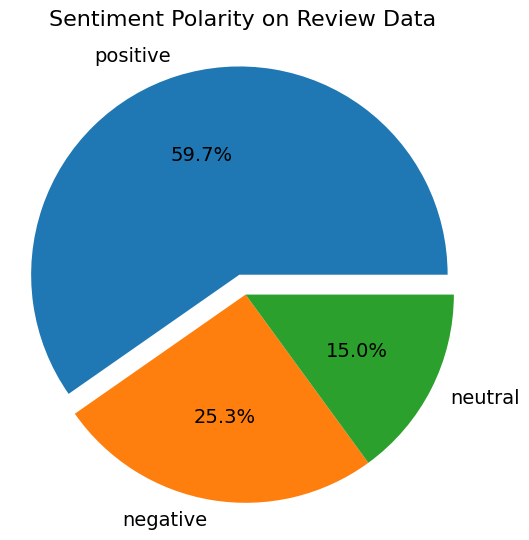

In [295]:
# --- VISUALISASI DATA ---
# Pie Chart Distribusi Polaritas
fig, ax = plt.subplots(figsize=(6, 6))
polarity_counts = df_filled['polarity'].value_counts()
sizes = [count for count in polarity_counts]
labels = list(polarity_counts.index)
explode = tuple([0.1 if i == 0 else 0 for i in range(len(labels))])
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
ax.axis('equal')
plt.show()

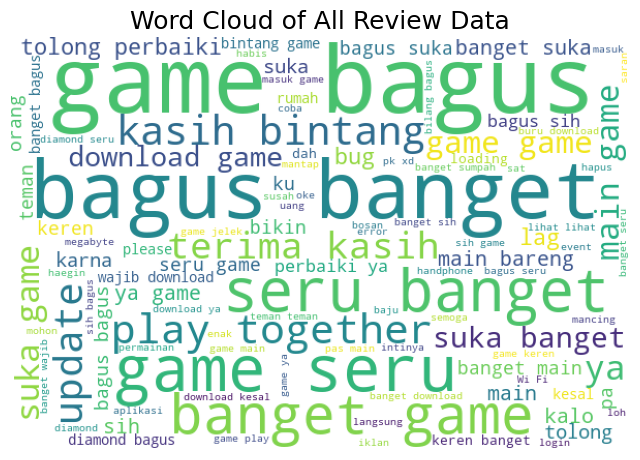

In [296]:
# --- Word Cloud untuk Semua Ulasan ---
list_words_all = ' '.join([' '.join(tokens) for tokens in df_filled['text_stopword']])
wordcloud_all = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words_all)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of All Review Data', fontsize=18)
ax.imshow((wordcloud_all))
ax.axis('off')
plt.show()

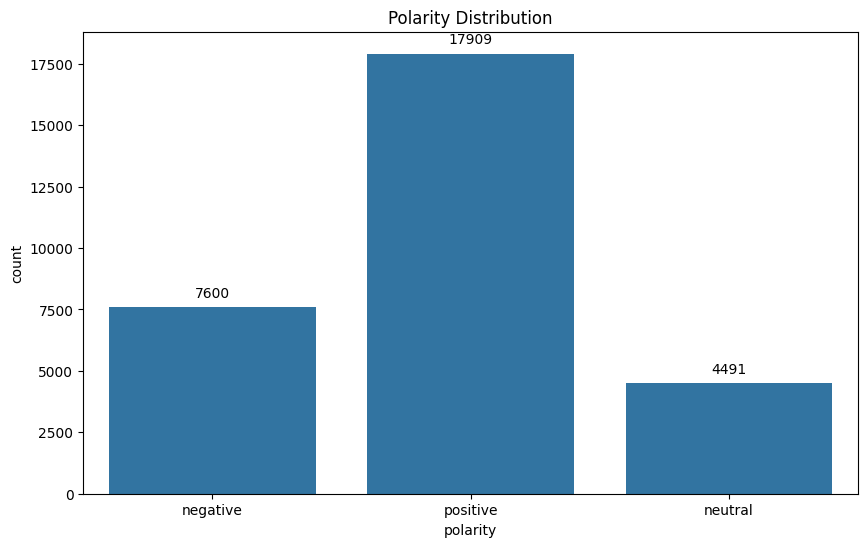

In [297]:
# --- Distribusi Polaritas ---
plt.figure(figsize=(10, 6))
class_dist_plot = sns.countplot(x='polarity', data=df_filled)
plt.title('Polarity Distribution')
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 10),
                            textcoords='offset points')
plt.show()

# Data Splitting dan Feature Extraction

In [298]:
# --- DATA SPLITTING DAN FEATURE EXTRACTION ---
label_encoder = LabelEncoder()
df_filled['sentiment_numeric'] = label_encoder.fit_transform(df_filled['polarity'])
X = df_filled['text_akhir']
y = df_filled['sentiment_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [299]:
# --- PERSIAPAN TOKENIZER (Batasi Vocabulary) ---
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
maxlen = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post', truncating='post')

# Modeling

In [300]:
# --- PERCOBAAN 1: CNN SEDERHANA (Lebih Ringan) ---
embedding_dim_cnn = 64
filters_cnn = 64
kernel_size_cnn = 3
dropout_rate_cnn = 0.1
epochs_cnn = 5
batch_size_cnn = 128

model_cnn = Sequential([
    Embedding(max_words, embedding_dim_cnn, input_length=maxlen),
    Conv1D(filters_cnn, kernel_size_cnn, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(dropout_rate_cnn),
    Dense(3, activation='softmax')
])

optimizer_cnn = Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer_cnn, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nMelatih Percobaan 1: CNN Sederhana (Ringan)...")
history_cnn = model_cnn.fit(X_train_padded, y_train_encoded, epochs=epochs_cnn, batch_size=batch_size_cnn,
                            validation_data=(X_test_padded, y_test_encoded),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)], verbose=1)

print("\nEvaluasi Percobaan 1: CNN Sederhana (Ringan)...")
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"Loss (CNN Ringan): {loss_cnn:.4f}")
print(f"Akurasi (CNN Ringan): {accuracy_cnn:.4f}")
y_pred_cnn = np.argmax(model_cnn.predict(X_test_padded), axis=-1)
y_true_cnn = np.argmax(y_test_encoded, axis=-1)
print("\nClassification Report (CNN Ringan):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=label_encoder.classes_))


Melatih Percobaan 1: CNN Sederhana (Ringan)...
Epoch 1/5


d:\Users\Reisya Junita\Documents\Laskar Ai\Materi\Pengembangan Machine Learning\proyek_analisis_sentiment\env_bpml\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6469 - loss: 0.8155 - val_accuracy: 0.8845 - val_loss: 0.3725
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9039 - loss: 0.2978 - val_accuracy: 0.9038 - val_loss: 0.2916
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9391 - loss: 0.1823 - val_accuracy: 0.9057 - val_loss: 0.2820
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9557 - loss: 0.1342 - val_accuracy: 0.9103 - val_loss: 0.2946
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9653 - loss: 0.1057 - val_accuracy: 0.9105 - val_loss: 0.3168

Evaluasi Percobaan 1: CNN Sederhana (Ringan)...
Loss (CNN Ringan): 0.2820
Akurasi (CNN Ringan): 0.9057
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report (CNN Ringan):
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      1520
     neutral       0.87      0.73      0.80       898
    positive       0.93  

In [301]:
# --- PERCOBAAN 2: LOGISTIC REGRESSION DENGAN TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_lr = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=100)
print("\nMelatih Percobaan 2: Logistic Regression dengan TF-IDF (Ringan)...")
model_lr.fit(X_train_tfidf, y_train)

y_pred_lr = model_lr.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nAkurasi (Logistic Regression + TF-IDF Ringan): {accuracy_lr:.4f}")
print("\nClassification Report (Logistic Regression + TF-IDF Ringan):")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


Melatih Percobaan 2: Logistic Regression dengan TF-IDF (Ringan)...


d:\Users\Reisya Junita\Documents\Laskar Ai\Materi\Pengembangan Machine Learning\proyek_analisis_sentiment\env_bpml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Akurasi (Logistic Regression + TF-IDF Ringan): 0.8692

Classification Report (Logistic Regression + TF-IDF Ringan):
              precision    recall  f1-score   support

    negative       0.82      0.86      0.84      1520
     neutral       0.92      0.45      0.60       898
    positive       0.88      0.98      0.93      3582

    accuracy                           0.87      6000
   macro avg       0.88      0.76      0.79      6000
weighted avg       0.87      0.87      0.86      6000



In [302]:
# --- PERCOBAAN 3: CNN SEDERHANA (Lebih KompleKS) ---
embedding_dim_final = 128
filters_final = 128
kernel_size_final = 5
dropout_rate_final = 0.2
epochs_final = 10
batch_size_final = 128

model_cnn_final = Sequential([
    Embedding(max_words, embedding_dim_final, input_length=maxlen),
    Conv1D(filters_final, kernel_size_final, activation='relu', padding='same'),
    Conv1D(filters_final, kernel_size_final, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate_final),
    Dense(3, activation='softmax')
])

optimizer_final = Adam(learning_rate=0.001)
model_cnn_final.compile(optimizer=optimizer_final, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nMelatih Model CNN Final...")
history_final = model_cnn_final.fit(X_train_padded, y_train_encoded, epochs=epochs_final, batch_size=batch_size_final,
                                    validation_data=(X_test_padded, y_test_encoded),
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                                    verbose=1)

print("\nEvaluasi Model CNN Final...")
loss_final, accuracy_final = model_cnn_final.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"Loss (CNN Final): {loss_final:.4f}")
print(f"Akurasi (CNN Final): {accuracy_final:.4f}")

y_pred_cnn_final = np.argmax(model_cnn_final.predict(X_test_padded), axis=-1)
y_true_cnn_final = np.argmax(y_test_encoded, axis=-1)
print("\nClassification Report (CNN Final):")
print(classification_report(y_true_cnn_final, y_pred_cnn_final, target_names=label_encoder.classes_))


Melatih Model CNN Final...
Epoch 1/10


d:\Users\Reisya Junita\Documents\Laskar Ai\Materi\Pengembangan Machine Learning\proyek_analisis_sentiment\env_bpml\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 178ms/step - accuracy: 0.7028 - loss: 0.7115 - val_accuracy: 0.8962 - val_loss: 0.3125
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.9251 - loss: 0.2180 - val_accuracy: 0.9130 - val_loss: 0.2740
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.9519 - loss: 0.1361 - val_accuracy: 0.9115 - val_loss: 0.2817
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.9630 - loss: 0.1085 - val_accuracy: 0.8945 - val_loss: 0.3455
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.9669 - loss: 0.0949 - val_accuracy: 0.9175 - val_loss: 0.3234

Evaluasi Model CNN Final...
Loss (CNN Final): 0.2740
Akurasi (CNN Final): 0.9130
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

Classification Report (CNN Final):
              precision    recall  f1-score   support

    negative       0.88      0.90      0.89      1520
     neutral       0.89      0.72      0.80       898
    positive       0.93      0.97

# Inference/ Testing Model

In [303]:
def infer_sentiment_simple(text, model, tokenizer, maxlen, label_encoder):
    processed_text = preprocess_text(text)
    text_sequences = tokenizer.texts_to_sequences([processed_text])
    text_padded = pad_sequences(text_sequences, maxlen=maxlen, padding='post', truncating='post')
    prediction_probabilities = model.predict(text_padded)
    predicted_class_index = np.argmax(prediction_probabilities)
    predicted_sentiment = label_encoder.classes_[predicted_class_index]
    return f"Prediksi Sentimen: {predicted_sentiment}"

In [304]:
# Contoh penggunaan fungsi inferensi
teks_inferensi = ["gamenya bagussss bangettt dan seru banyak dapetin diamond",
                  "gamenya jelekkkk, banyak bug dan iklannya",
                  "Tidak ada yang baru dalam versi ini."]

print("Hasil Inferensi untuk Beberapa Teks:")
for teks in teks_inferensi:
    hasil_inferensi = infer_sentiment_simple(teks, model_cnn_final, tokenizer, maxlen, label_encoder)
    print(f"Teks: '{teks}' - {hasil_inferensi}")

Hasil Inferensi untuk Beberapa Teks:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Teks: 'gamenya bagussss bangettt dan seru banyak dapetin diamond' - Prediksi Sentimen: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Teks: 'gamenya jelekkkk, banyak bug dan iklannya' - Prediksi Sentimen: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Teks: 'Tidak ada yang baru dalam versi ini.' - Prediksi Sentimen: neutral
